# Week 9 Exercise
## lillian Mueller 

1. generate decision tree logistic tree models for flight dataset 
2. generate ROC curves for each model
3. Determine which model I would select 

In [315]:
import pandas as pd 
import numpy as np 
import math
from sklearn import (
    tree, 
    linear_model, 
    metrics, 
    model_selection
)
import matplotlib.pyplot as plt

## Cleaning the data

In [316]:
# using 2008 flight data
y2008 = pd.read_csv('dataverse_files/2008.csv.bz2', compression='bz2')
y2008 = y2008.drop(columns=['Year', 'DayofMonth','CRSDepTime',
       'ArrTime', 'CRSArrTime','FlightNum', 'TailNum', 'Cancelled',
       'ActualElapsedTime', 'CRSElapsedTime', 'Distance', 'AirTime', 'ArrDelay',
       'DepDelay', 'TaxiIn', 'TaxiOut', 'CancellationCode', 'Diverted'])

# clean Delay colmuns 
delayCols = ['NASDelay','SecurityDelay','LateAircraftDelay','CarrierDelay', 'WeatherDelay']
for col in delayCols: 
    y2008[col] = y2008[col].fillna(0)

# drop rest of entries with NaN 
y2008.dropna(inplace=True)

# only investigating 
print(y2008.columns, len(y2008.index))
print(y2008.sample(10, random_state=3))

Index(['Month', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay'],
      dtype='object') 2324775
         Month  DayOfWeek  DepTime UniqueCarrier Origin Dest  CarrierDelay  \
1645158      3          6    656.0            9E    ALO  MSP           0.0   
1034341      2          5    730.0            9E    MSN  LGA           0.0   
1771246      3          7   1252.0            DL    SNA  SLC           0.0   
1523442      3          2   1221.0            EV    PHF  ATL           0.0   
1200675      3          2   1854.0            WN    AUS  DAL           0.0   
1591613      3          4   1051.0            MQ    SYR  ORD           0.0   
1157621      2          4    538.0            CO    LGA  IAH           0.0   
346570       1          2    825.0            F9    DEN  SLC           0.0   
1885477      4          2    654.0            XE    OKC  ABQ           0.0   
1471879      3    

In [317]:
# add total delay column 
y2008['TotalDelay'] = (
    y2008['CarrierDelay'] + 
    y2008['WeatherDelay'] + 
    y2008['NASDelay'] + 
    y2008['SecurityDelay'] + 
    y2008['LateAircraftDelay']
)

# add weather delay feature, 0 = no, 1 = yes
y2008['WeatherDelay'] = [ 1 if delay>0  else 0 for delay in y2008['WeatherDelay']]

# drop delay data 
y2008 = y2008.drop(columns=['NASDelay','SecurityDelay','LateAircraftDelay','CarrierDelay'])
y2008.sample(10, random_state=3)

,Month,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,WeatherDelay,TotalDelay
1645158,3,6,656.0,9E,ALO,MSP,0,0.0
1034341,2,5,730.0,9E,MSN,LGA,0,30.0
1771246,3,7,1252.0,DL,SNA,SLC,0,0.0
1523442,3,2,1221.0,EV,PHF,ATL,0,0.0
1200675,3,2,1854.0,WN,AUS,DAL,0,0.0
1591613,3,4,1051.0,MQ,SYR,ORD,0,0.0
1157621,2,4,538.0,CO,LGA,IAH,0,0.0
346570,1,2,825.0,F9,DEN,SLC,0,0.0
1885477,4,2,654.0,XE,OKC,ABQ,0,0.0
1471879,3,5,1328.0,US,PHX,CLT,0,0.0


In [318]:
# clean depTime - use only hour
y2008['DepTime'] = y2008['DepTime'] / 100.0
y2008['DepTime'] = y2008['DepTime'].astype(int)
y2008.sample(10, random_state=3)

,Month,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,WeatherDelay,TotalDelay
1645158,3,6,6,9E,ALO,MSP,0,0.0
1034341,2,5,7,9E,MSN,LGA,0,30.0
1771246,3,7,12,DL,SNA,SLC,0,0.0
1523442,3,2,12,EV,PHF,ATL,0,0.0
1200675,3,2,18,WN,AUS,DAL,0,0.0
1591613,3,4,10,MQ,SYR,ORD,0,0.0
1157621,2,4,5,CO,LGA,IAH,0,0.0
346570,1,2,8,F9,DEN,SLC,0,0.0
1885477,4,2,6,XE,OKC,ABQ,0,0.0
1471879,3,5,13,US,PHX,CLT,0,0.0


In [319]:
# select only data entries where the origin was 
origin = ['BWI', 'DCA', 'IAD']
# select only data entries where the destination was 
dest = ['EWR', 'JFK', 'LGA']

y2008 = y2008.loc[(y2008['Origin'].isin(origin)) & (y2008['Dest'].isin(dest))]
print('length:', len(y2008.index))
y2008.sample(10, random_state=3)

length: 7379


,Month,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,WeatherDelay,TotalDelay
852660,2,2,11,US,DCA,LGA,0,0.0
890346,2,4,9,DL,DCA,LGA,0,34.0
1120460,2,3,19,B6,IAD,JFK,0,32.0
876680,2,7,15,US,DCA,LGA,0,0.0
1001023,2,2,17,MQ,DCA,LGA,0,0.0
2204284,4,7,6,MQ,DCA,LGA,0,0.0
2337006,4,1,8,B6,IAD,JFK,0,0.0
909207,2,5,9,DL,DCA,LGA,0,22.0
905286,2,2,16,DL,DCA,LGA,0,0.0
242600,1,6,8,UA,IAD,LGA,0,0.0


In [320]:
# create code for carrier, using its index in carriers.csv
carriers = pd.read_csv('dataverse_files/carriers.csv')
carriers.head()
y2008['UniqueCarrier'] = [(carriers.index[carriers['Code'] == carrier]).values[0] for carrier in y2008['UniqueCarrier']]

# encode airports
y2008['Dest'] = y2008['Dest'].replace({
    'EWR':0,
    'JFK':1,
    'LGA':2
})
y2008['Origin'] = y2008['Origin'].replace({
    'BWI':0, 
    'DCA':1, 
    'IAD':2
})

y2008.sample(10, random_state=3)

,Month,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,WeatherDelay,TotalDelay
852660,2,2,11,1308,1,2,0,0.0
890346,2,4,9,441,1,2,0,34.0
1120460,2,3,19,263,2,1,0,32.0
876680,2,7,15,1308,1,2,0,0.0
1001023,2,2,17,848,1,2,0,0.0
2204284,4,7,6,848,1,2,0,0.0
2337006,4,1,8,263,2,1,0,0.0
909207,2,5,9,441,1,2,0,22.0
905286,2,2,16,441,1,2,0,0.0
242600,1,6,8,1297,2,2,0,0.0


In [321]:
# create delay scale 
def delay(minutes):
    if minutes == 0:
        # no delay 
        return 0
    else: 
        # delay 
        return 1

y2008['TotalDelay15'] = [delay(minutes) for minutes in y2008['TotalDelay']]
print(len(y2008.index))
print('0:', np.array([1 if x ==0 else 0 for x in y2008['TotalDelay15']]).sum())
print('1:', np.array([1 if x ==1 else 0 for x in y2008['TotalDelay15']]).sum())
y2008.sample(10, random_state=3)

7379
0: 5230
1: 2149


,Month,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,WeatherDelay,TotalDelay,TotalDelay15
852660,2,2,11,1308,1,2,0,0.0,0
890346,2,4,9,441,1,2,0,34.0,1
1120460,2,3,19,263,2,1,0,32.0,1
876680,2,7,15,1308,1,2,0,0.0,0
1001023,2,2,17,848,1,2,0,0.0,0
2204284,4,7,6,848,1,2,0,0.0,0
2337006,4,1,8,263,2,1,0,0.0,0
909207,2,5,9,441,1,2,0,22.0,1
905286,2,2,16,441,1,2,0,0.0,0
242600,1,6,8,1297,2,2,0,0.0,0


## Generating the Models

In [322]:
## Separating the features and target data subsets 
target = np.array(y2008['TotalDelay15'])
features = y2008.drop(columns=['TotalDelay', 'TotalDelay15']).values

# split dataset into training and testing dataset
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    features, 
    target, 
    test_size = 0.33, 
    random_state=8, 
    )

In [323]:
# create decision tree model using same training and test datasets 
dTree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3).fit(x_train, y_train)

# Test model with testing dataset and find accuracy 
dtree_pred = dTree.predict(x_test)

# get classification report 
print(
    'Classification Report for Decision Tree Model\n', 
    metrics.classification_report(y_test, dtree_pred))

results = {
    'DTree' : [
        metrics.accuracy_score(y_test, dtree_pred), 
        metrics.recall_score(y_test, dtree_pred, average='weighted'), 
        metrics.precision_score(y_test, dtree_pred, average=None)
    ]
}
print(results['DTree'])

Classification Report for Decision Tree Model
               precision    recall  f1-score   support

           0       0.69      1.00      0.82      1679
           1       1.00      0.01      0.02       757

    accuracy                           0.69      2436
   macro avg       0.85      0.50      0.42      2436
weighted avg       0.79      0.69      0.57      2436

[0.6921182266009852, 0.6921182266009852, array([0.69123096, 1.        ])]


In [324]:
# create logistic regression model using same training and test datasets 
logR = linear_model.LogisticRegression(penalty=None).fit(x_train, y_train)

# Test model with testing dataset and find accuracy 
logR_pred = logR.predict(x_test)

# get classification report 
print(
    'Classification Report for Logistic Regression Model\n', 
    metrics.classification_report(y_test, logR_pred))

results['LogReg'] = [
        metrics.accuracy_score(y_test, logR_pred), 
        metrics.recall_score(y_test, logR_pred, average=None), 
        metrics.precision_score(y_test, logR_pred, average=None)
    ]

print(results['LogReg'])

Classification Report for Logistic Regression Model
               precision    recall  f1-score   support

           0       0.72      0.96      0.82      1679
           1       0.66      0.15      0.25       757

    accuracy                           0.71      2436
   macro avg       0.69      0.56      0.54      2436
weighted avg       0.70      0.71      0.64      2436

[0.7122331691297209, array([0.96426444, 0.15323646]), array([0.71637168, 0.65909091])]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Generating ROC Curves and Area under the Curve (AUC)

AUC: 0.5046235138705416


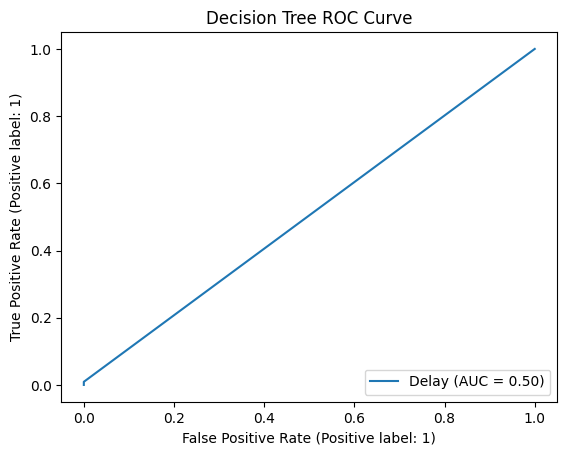

In [325]:
# decision tree model 

dtree_fpr, dtree_tpr, dtree_thresholds = metrics.roc_curve(y_test, dtree_pred)
dtree_auc = metrics.auc(dtree_fpr, dtree_tpr)
print('AUC:', dtree_auc)

# ROC Curve 
metrics.RocCurveDisplay.from_predictions(y_test, dtree_pred, name='Delay')
plt.title('Decision Tree ROC Curve')
plt.savefig('dtree_roc.png')
plt.show()

AUC: 0.5587504514151422


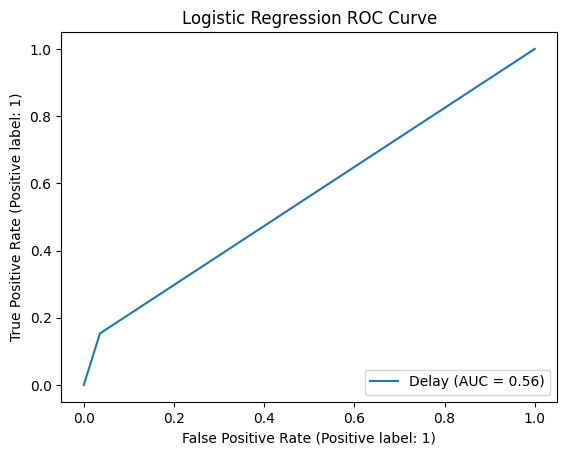

In [326]:
# logistic regression model 

logR_fpr, logR_tpr, logR_thresholds = metrics.roc_curve(y_test, logR_pred)
logR_auc = metrics.auc(logR_fpr, logR_tpr)
print('AUC:', logR_auc)

# ROC Curve 
metrics.RocCurveDisplay.from_predictions(y_test, logR_pred, name='Delay')
plt.title('Logistic Regression ROC Curve')
plt.savefig('logR_roc.png')
plt.show()

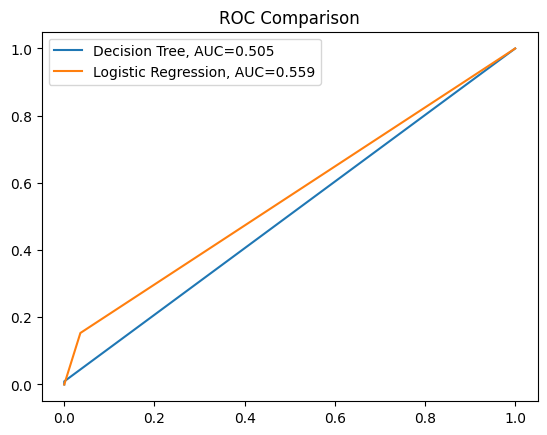

In [327]:
plt.figure(1).clf()
plt.plot(dtree_fpr,dtree_tpr,label="Decision Tree, AUC="+str(round(dtree_auc,3)))
plt.plot(logR_fpr,logR_tpr,label="Logistic Regression, AUC="+str(round(logR_auc, 3)))
plt.legend()
plt.title('ROC Comparison')
plt.savefig('rocCurves.png')
plt.show()

## Cross Validation for Accuracy
Functions taken from hw4

In [328]:
# Comparison of score means and standard deviation 
# create table comparing average and std of multiple dataframes
def comparison_table(dfs, columns):
    meanScores = pd.concat(
        [df.mean() for df in dfs], 
        axis=1)
    meanScores.columns = [col for col in columns]

    stdScores = pd.concat(
        [df.std() for df in dfs], 
        axis=1)
    stdScores.columns = [col for col in columns]

    comparison = pd.concat([meanScores, stdScores], ignore_index=True)
    comparison.index = ['Mean', 'Stardard Dev.']
    return comparison
    
def cross_val(numfolds):

    logR_cross_val = model_selection.cross_val_score(
        linear_model.LogisticRegression(penalty=None), 
        features, 
        target, 
        cv = numfolds,
        scoring='accuracy'
    )
    logR = pd.DataFrame(logR_cross_val)
    # print(logR)
    dtree_cross_val = model_selection.cross_val_score(
        tree.DecisionTreeClassifier(criterion='entropy', max_depth=3), 
        features, 
        target, 
        cv = numfolds,
        scoring='accuracy'
    )
    dtree = pd.DataFrame(dtree_cross_val)
    # print(dtree)
    return comparison_table([logR, dtree], ['Logistic Regression', 'Decision Tree'])

In [329]:
numfolds = 10
print('group size:', len(y2008.index)/numfolds)
cross_val(numfolds)

group size: 737.9


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

,Logistic Regression,Decision Tree
Mean,0.697252,0.680720
Stardard Dev.,0.023287,0.042244
